# Combine Models From Multiple Runs With Model Averaging Ensemble

Deep learning neural network models are highly flexible nonlinear algorithms capable of learning a nearly infinite number of mapping functions. Frustration with this flexibility is the high variance in a final model. The same neural network model trained on the same dataset may nd one of many different possible good enough solutions each time it is run. In this tutorial, you will discover how to develop a model averaging ensemble in Keras to reduce the variance in a final model. Model averaging is an ensemble learning technique that reduces the variance in a final neural network model, sacrificing spread (and possibly better scores) in the model's performance for confidence in what performance to expect from the model. After completing this tutorial, you will know:

* Model averaging is an ensemble learning technique that can be used to reduce the expected variance of deep learning neural network models.
* How to implement model averaging in Keras for classification and regression predictive modeling problems.
* How to work through a multiclass classification problem and use model averaging to reduce the variance of the final model.

## Model Averaging Ensemble

Deep learning neural network models are nonlinear methods that learn via a stochastic training algorithm. This means that they are highly flexible, capable of learning complex relationships between variables and approximating any mapping function, given enough resources. A downside of this flexibility is that the models suffer high variance. This means that the models are highly dependent on the specific training data used to train the model and on the initial conditions (random initial weights) and serendipity during the training process. The result is a final model that makes different predictions each time the same model configuration is trained on the same dataset.

This can be frustrating when training a final model to make predictions on new data, such as operationally or in a machine learning competition. The high variance of the approach can be addressed by training multiple models for the problem and combining their predictions. This approach is called model averaging and belongs to a family of techniques called ensemble learning.

## Ensembles in Keras

The simplest way to develop a model averaging ensemble in Keras is to train multiple models on the same dataset then combine the predictions from each of the trained models.

### Train Multiple Models

Training multiple models may be resource-intensive, depending on the size of the model and the size of the training data. You may have to train the models sequentially on the same hardware. For very large models, it may be worth training the models in parallel using cloud infrastructure
such as Amazon Web Services.

The number of models required for the ensemble may vary based on the complexity of the problem and model. A benefit of the approach is that you can continue creating models, adding them to the ensemble, and evaluating their impact on the performance by making predictions on a holdout test set. You can train the models sequentially for small models and keep them in memory for use in your experiment. For example:

```
...
# train models and keep them in memory
n_members = 10
models = list()
for _ in range(n_members):
    # define and fit model
    model = ...
    
    # store model in memory as ensemble member
    models.add(models)
...
```

For large models, perhaps trained on different hardware, you can save each model to a file.

```
...
# train models and keep them to file
n_members = 10
for i in range(n_members):
    # define and fit model
    model = ...

    # save model to file
    filename = 'model_' + str(i + 1) + '.h5'
    model.save(filename)
    
    print('Saved: %s' % filename)
...
```

Models can then be loaded later. Small models can all be loaded into memory simultaneously, whereas very large models may have to be loaded one at a time to make a prediction, then later to have the predictions combined.

```
from tensorflow.keras.models import load_model
...

# load pre-trained ensemble members
n_members = 10
models = list()

for i in range(n_members):
    # load model
    filename = 'model_' + str(i + 1) + '.h5'
    model = load_model(filename)

    # store in memory
    models.append(model)
...
```

### Combine Predictions

Once the models have been prepared, each model can be used to predict, and the predictions can be combined. In a regression problem where each model predicts a real-valued output, the values can be collected, and the average is calculated.

```
...
# make predictions
yhats = [model.predict(testX) for model in models]
yhats = array(yhats)

# calculate average
outcomes = mean(yhats)
```

In the case of a classification problem, there are two options: to combine the predicted class labels or to combine the predicted probabilities. The class labels can be combined by calculating the statistical mode (most frequent value), for example:

```
...
# make predictions
yhats = [model.predict_classes(testX) for model in models]
yhats = array(yhats)

# calculate mode
outcomes, _ = mode(yhats)
```

A downside of this approach is that for small ensembles or problems with a large number of classes, the sample of predictions may not be large enough for the mode to be meaningful. A sigmoid activation function is used on the output layer in a binary classification problem, and the average of the predicted probabilities can be calculated much like a regression problem. In the case of a multiclass classification problem with more than two classes, a softmax activation function is used on the output layer, and the sum of the probabilities for each predicted class can be calculated before taking the argmax to get the class value, for example:

```
...
# make predictions
yhats = [model.predict(testX) for model in models]
yhats = array(yhats)

# sum across ensembles
summed = numpy.sum(yhats, axis=0)

# argmax across classes
outcomes = argmax(summed, axis=1)
```

These approaches for combining predictions of Keras models will work just as well for Multilayer Perceptron, Convolutional, and Recurrent Neural Networks. Now that we know how to average predictions from multiple neural network models in Keras, let us work through a case study.

## Model Averaging Ensemble Case Study

In this section, we will demonstrate how to use the model average ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the model average ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate a model averaging ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 500 examples, with two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same 500 points.

In [13]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

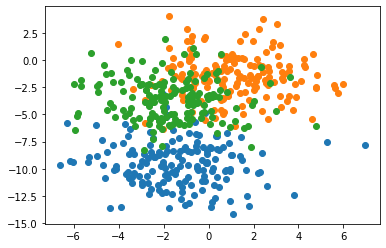

In [14]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### MLP Model for Multiclass Classification

Now that we have defined a problem, we can define a model to address it. We will define a model that is perhaps under-constrained and not tuned to the problem. This is intentional to demonstrate the high variance of a neural network model seen on truly large and challenging supervised learning problems. 

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [15]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)

Next, we must split the dataset into training and test sets. We will use the test set both to evaluate the model's performance and to plot its performance during training with a learning curve. We will use 30% of the data for training and 70% for the test set. This is an example of a challenging problem where we have more unlabeled examples than labeled ones.

In [16]:
# split into train and test
n_train = int(0.3 * X.shape[0])

trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 15 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 200 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [18]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=1)

Epoch 1/200
5/5 [==============================] - 2s 75ms/step - loss: 4.0664 - accuracy: 0.3722 - val_loss: 3.2036 - val_accuracy: 0.3686
Epoch 2/200
5/5 [==============================] - 0s 8ms/step - loss: 4.0946 - accuracy: 0.3443 - val_loss: 3.0335 - val_accuracy: 0.3771
Epoch 3/200
5/5 [==============================] - 0s 9ms/step - loss: 3.3914 - accuracy: 0.3530 - val_loss: 2.8710 - val_accuracy: 0.3914
Epoch 4/200
5/5 [==============================] - 0s 8ms/step - loss: 3.5402 - accuracy: 0.3487 - val_loss: 2.7128 - val_accuracy: 0.4029
Epoch 5/200
5/5 [==============================] - 0s 8ms/step - loss: 3.1425 - accuracy: 0.3726 - val_loss: 2.5581 - val_accuracy: 0.4086
Epoch 6/200
5/5 [==============================] - 0s 8ms/step - loss: 3.0461 - accuracy: 0.3593 - val_loss: 2.4102 - val_accuracy: 0.4143
Epoch 7/200
5/5 [==============================] - 0s 8ms/step - loss: 2.8757 - accuracy: 0.3961 - val_loss: 2.2662 - val_accuracy: 0.4229
Epoch 8/200
5/5 [=========

5/5 [==============================] - 0s 8ms/step - loss: 0.5581 - accuracy: 0.7509 - val_loss: 0.8166 - val_accuracy: 0.6429
Epoch 60/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5308 - accuracy: 0.7643 - val_loss: 0.8139 - val_accuracy: 0.6457
Epoch 61/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5212 - accuracy: 0.7374 - val_loss: 0.8117 - val_accuracy: 0.6486
Epoch 62/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5984 - accuracy: 0.6905 - val_loss: 0.8090 - val_accuracy: 0.6486
Epoch 63/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5288 - accuracy: 0.7548 - val_loss: 0.8063 - val_accuracy: 0.6486
Epoch 64/200
5/5 [==============================] - 0s 9ms/step - loss: 0.5285 - accuracy: 0.7491 - val_loss: 0.8035 - val_accuracy: 0.6486
Epoch 65/200
5/5 [==============================] - 0s 9ms/step - loss: 0.5576 - accuracy: 0.7144 - val_loss: 0.8008 - val_accuracy: 0.6514
Epoch 66/200
5/5 [===============

5/5 [==============================] - 0s 8ms/step - loss: 0.4947 - accuracy: 0.7983 - val_loss: 0.6913 - val_accuracy: 0.7000
Epoch 118/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5023 - accuracy: 0.7662 - val_loss: 0.6894 - val_accuracy: 0.7057
Epoch 119/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4893 - accuracy: 0.7861 - val_loss: 0.6877 - val_accuracy: 0.7057
Epoch 120/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5380 - accuracy: 0.7449 - val_loss: 0.6855 - val_accuracy: 0.7114
Epoch 121/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4897 - accuracy: 0.7809 - val_loss: 0.6836 - val_accuracy: 0.7143
Epoch 122/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4656 - accuracy: 0.7901 - val_loss: 0.6819 - val_accuracy: 0.7143
Epoch 123/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4576 - accuracy: 0.7844 - val_loss: 0.6804 - val_accuracy: 0.7143
Epoch 124/200
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.3592 - accuracy: 0.8560 - val_loss: 0.6062 - val_accuracy: 0.7600
Epoch 176/200
5/5 [==============================] - 0s 8ms/step - loss: 0.3532 - accuracy: 0.8603 - val_loss: 0.6054 - val_accuracy: 0.7600
Epoch 177/200
5/5 [==============================] - 0s 8ms/step - loss: 0.3800 - accuracy: 0.8547 - val_loss: 0.6042 - val_accuracy: 0.7629
Epoch 178/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4000 - accuracy: 0.8443 - val_loss: 0.6029 - val_accuracy: 0.7600
Epoch 179/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4133 - accuracy: 0.8378 - val_loss: 0.6018 - val_accuracy: 0.7600
Epoch 180/200
5/5 [==============================] - 0s 8ms/step - loss: 0.3578 - accuracy: 0.8729 - val_loss: 0.6007 - val_accuracy: 0.7600
Epoch 181/200
5/5 [==============================] - 0s 8ms/step - loss: 0.3711 - accuracy: 0.8603 - val_loss: 0.5995 - val_accuracy: 0.7600
Epoch 182/200
5/5 [========

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [19]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.853, Test: 0.771


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

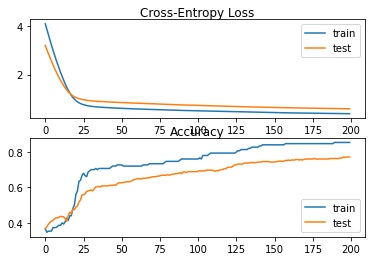

In [20]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [21]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.853, Test: 0.763


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 84% accuracy on the training dataset and 76 % accuracy on the test dataset, which is not terrible.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that the model is not really overfitting but is perhaps a little underfit and may benefit from an increase in capacity, more training, and perhaps some regularization. We intentionally hold back all of these improvements to force high variance for our case study.

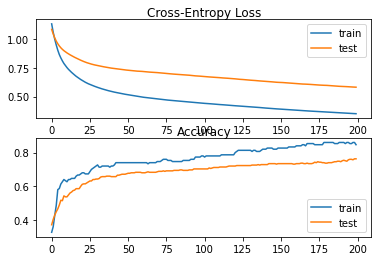

In [23]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

### High Variance of MLP Model

### Model Averaging Ensemble

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Average Class Prediction**. Update the example to average the class integer prediction instead of the class probability prediction and compare results.
* **Save and Load Models**. Update the example to save ensemble members to a file, then load them from a separate script for evaluation.
* **Sensitivity of Variance**. Create a new example that performs a sensitivity analysis of the number of ensemble members on the standard deviation of model performance on the test set over a given number of repeats and report the point of diminishing returns.

## Summary

In this tutorial, you discovered how to develop a model averaging ensemble in Keras to reduce the variance in a final model. Specifically, you learned:

* Model averaging is an ensemble learning technique that can be used to reduce the expected variance of deep learning neural network models.
* How to implement model averaging in Keras for classification and regression predictive modeling problems.
* How to work through a multiclass classification problem and use model averaging to reduce the variance of the final model.